In [1]:
import tensorflow as tf
import scipy
import keras.backend as K
import imghdr

from keras.models import load_model
from yolo_utils import *
from matplotlib.pyplot import imshow
from PIL import Image

/Users/varunnag/.virtualenvs/deep_learning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<h2>Convert the output layer to bounding box</h2>

Lets explore the output layer a bit

Output layer has dimensions 19x19x425. 

<ol>
    <li>The CNN generates a 19x19 gird for determining the object location</li>
    <li>Each location in the grid will contain a values for each of the anchor box. I this case there are 5 anchor boxes of diffrent dimensions.</li>
    <li>
        Each anchor box will contain following values
        <ol>
            <li>Probability of having an object</li>
            <li>Dimensions of the bounding box. Location of the center of the box (x,y) and Dimensions of the box (width, height) (4)</li>
            <li>Class of the object in the bounding box. In this case there are 80 classes and each class is represented as a vector of size 80.</li>
        </ol>
    </li>
</ol>

Hence we have the following dimensions 19x19x(5 x (1 + 4 + 80)). Instead of representing the output layer as a 4D matrix it is computationaly simpler to just vectorize the last 2 dimensions. hence we get 19x19x425

In [2]:
def get_grid_indices(output_layer, grid):
    width_indices = K.arange(0, stop=grid[1])
    width_indices = K.tile(K.expand_dims(width_indices, axis=0), (grid[0], 1))
    height_indices = K.arange(0, stop=grid[0])
    height_indices = K.tile(K.expand_dims(height_indices, axis=0), (grid[1], 1))
    height_indices = K.transpose(height_indices)
    indices = K.stack([width_indices, height_indices], axis=-1)
    indices = K.reshape(indices, (1, grid[0], grid[1], 1, 2))
    return K.cast(indices, K.dtype(output_layer))

def unroll_boxes(output_layer, anchors, num_classes):
    num_anchors = len(anchors)
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])
    
    grid = K.shape(output_layer)[1:3]
    
    grid_indices = get_grid_indices(output_layer, grid)

    output_layer = K.reshape(output_layer, [-1, grid[0], grid[1], num_anchors, num_classes + 5])
    grid = K.cast(K.reshape(grid, [1, 1, 1, 1, 2]), K.dtype(output_layer))
    
    box_centers = K.sigmoid(output_layer[...,:2])
    box_dims = K.exp(output_layer[...,2:4])
    box_confidence = K.sigmoid(output_layer[...,4:5])
    box_class_probs = K.softmax(output_layer[...,5:])
    
    
    box_centers = (box_centers + grid_indices)/ grid
    box_dims = (box_dims*anchors_tensor)/ grid
    
    return box_centers, box_dims, box_confidence, box_class_probs

<h1>Get box corners for drawing boxes on the image</h1>

In [3]:
def boxes_to_corners(box_centers, box_dims):
    box_mins = box_centers - (box_dims / 2.)
    box_maxes = box_centers + (box_dims / 2.)

    return K.concatenate([
        box_mins[..., 1:2],
        box_mins[..., 0:1],
        box_maxes[..., 1:2],
        box_maxes[..., 0:1]
    ])

<h1>Filter Boxes</h1>
<p>Filter out boxes that has probabilities of conataining an object less than the threshold value</p>
<p>Filter out overlapping boxes</p>

In [4]:
import tensorflow as tf

def filter_boxes(box_confidence, boxes, box_class_probs, threshold=0.6):
    box_scores = tf.multiply(box_confidence, box_class_probs)
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    filtering_mask = box_class_scores >= threshold
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    return scores, boxes, classes

def non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    return scores, boxes, classes

In [5]:
def get_boxes(output_layer, anchors, classes, image_shape = (720., 1280.), thresholds={}):
    num_classes = len(classes)
    box_centers, box_dims, box_confidence, box_class_probs = unroll_boxes(output_layer, anchors, num_classes)
    boxes = boxes_to_corners(box_centers, box_dims)
    scores, boxes, classes = filter_boxes(box_confidence, boxes, box_class_probs, threshold=thresholds.get('filter', 0.6))
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = non_max_suppression(scores, boxes, classes, iou_threshold=thresholds.get('iou', 0.5))
    return  scores, boxes, classes

In [6]:
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data


In [7]:
def eval_image(image_file, thresholds={}):
    obj_classes = open('./coco_classes.txt', 'r').readlines()
    obj_classes = list(map(lambda cls: cls.strip(), obj_classes))
    num_classes = len(obj_classes)
    anchors = [[0.57273, 0.677385], [1.87446, 2.06253], [3.33843, 5.47434], [7.88282, 3.52778], [9.77052, 9.16828]]
    colors = generate_colors(obj_classes)
    sess = K.get_session()
    image, image_data = preprocess_image(os.path.join("images", image_file), model_image_size=(608, 608))
    model = load_model("./yolo.h5")
    image_size = image.size
    scores, boxes, classes = get_boxes(model.output, anchors, obj_classes, thresholds=thresholds, image_shape=(float(image_size[1]), float(image_size[0])))
    [out_scores, out_boxes, out_classes] = sess.run([scores, boxes, classes], feed_dict={model.input: image_data, K.learning_phase(): 0})
    draw_boxes(image, out_scores, out_boxes, out_classes, obj_classes, colors)
    image.save(os.path.join("out", image_file), quality=90)
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)

/Users/varunnag/.virtualenvs/deep_learning/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


car 0.44 (0, 548) (82, 633)
car 0.51 (78, 561) (166, 626)
traffic light 0.51 (776, 73) (828, 188)
car 0.58 (181, 564) (247, 604)
traffic light 0.67 (454, 327) (478, 383)
car 0.67 (1036, 525) (1275, 734)


/Users/varunnag/.virtualenvs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


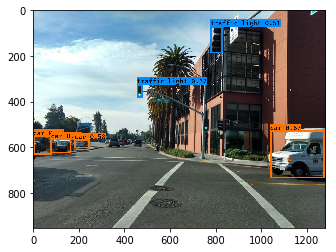

In [17]:
eval_image("testAWS.jpg", thresholds={
    'filter': 0.4,
    'iou': 0.5
})

/Users/varunnag/.virtualenvs/deep_learning/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


car 0.44 (336, 296) (378, 335)
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)


/Users/varunnag/.virtualenvs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


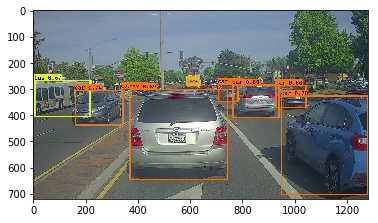

In [9]:
eval_image("test.jpg", thresholds={
    'filter': 0.4,
    'iou': 0.5
})

/Users/varunnag/.virtualenvs/deep_learning/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


car 0.11 (901, 532) (920, 549)
car 0.14 (675, 560) (695, 577)
car 0.28 (824, 544) (854, 564)
car 0.30 (634, 557) (667, 582)
car 0.55 (750, 553) (795, 584)
traffic light 0.63 (631, 325) (688, 522)
car 0.72 (0, 573) (76, 639)


/Users/varunnag/.virtualenvs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


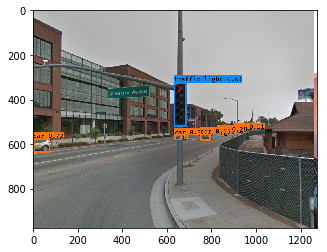

In [15]:
eval_image("testaws2.jpg", thresholds={
    'filter': 0.1,
    'iou': 0.3
})

/Users/varunnag/.virtualenvs/deep_learning/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


person 0.55 (1483, 1193) (1639, 1740)
person 0.55 (2, 1128) (129, 1763)
person 0.70 (1579, 1123) (1881, 1853)
person 0.72 (982, 1265) (1142, 1712)
person 0.77 (1148, 896) (1562, 2228)
person 0.79 (129, 999) (491, 1940)
person 0.80 (410, 827) (973, 2322)


/Users/varunnag/.virtualenvs/deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


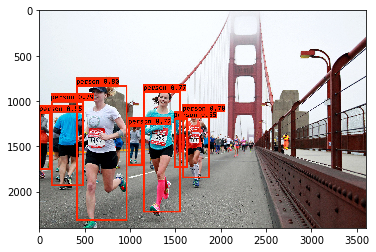

In [18]:
eval_image("sfmarathon.jpg", thresholds={
    'filter': 0.4,
    'iou': 0.5
})